In [1]:
import sys
sys.path.append('../../')
import opticalcoating as oc

# Инициализация дизайна

## Простейший дизайн без дисперсии

### Объявление

In [2]:
# Данные
des_name = 'RAMP19'
d = [0.0, 11.312, 52.599, 40.663, 29.844, 48.71, 64.411, 22.164, 74.8, 46.238, 39.479, 39.97, 
     79.953, 36.046, 47.032, 49.216, 83.599, 51.294, 81.827, 52.024]
n_const = [1.52, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35]

# Создание дизайна
des = oc.Design(d=d, n_const=n_const)

In [4]:
# Сохранение простейшего дизайна в json
des.create_simple_json(name=des_name)

### Загрузка дизайна

In [5]:
# Если дизайн уже есть, то загружаем его так:
des_name = 'RAMP19'
des = oc.Design(name=des_name)

# Свойства дизайна

In [6]:
# Толщины
print('Толщины:', des.d)
# Показатели преломления
print('Показатели преломления:', des.n_const)

Толщины: [0.0, 11.312, 52.599, 40.663, 29.844, 48.71, 64.411, 22.164, 74.8, 46.238, 39.479, 39.97, 79.953, 36.046, 47.032, 49.216, 83.599, 51.294, 81.827, 52.024]
Показатели преломления: [1.52, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35, 1.46, 2.35]


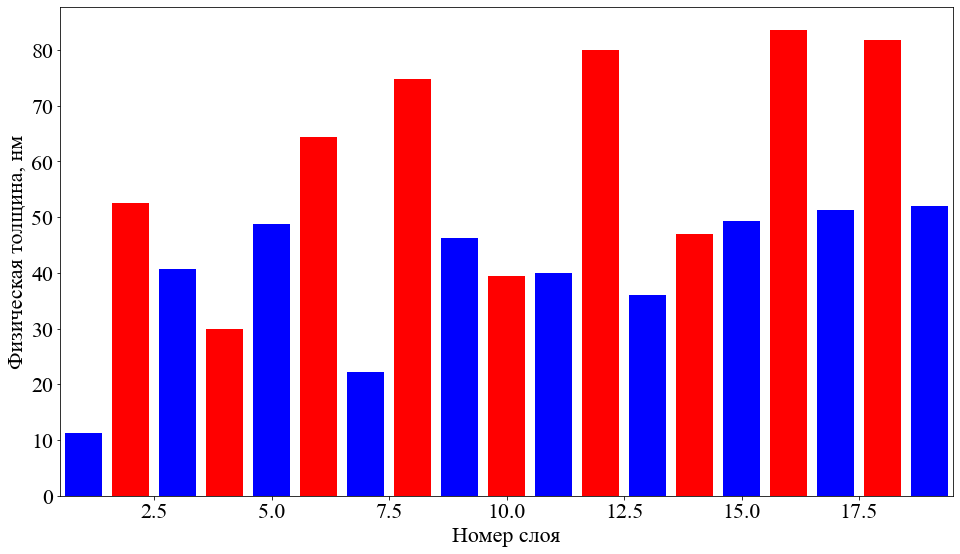

In [7]:
des.thickness_bar(lang='ru')

In [7]:
# Вычисление коэффициента пропускания T на длине волны 550 нм  со спектральной шириной щели 0.1 нм (абсолютное значение)
des.calc_flux(oc.Wave(550), q_subs=True, q_TR='T', width=0.1)

0.3696677520623806

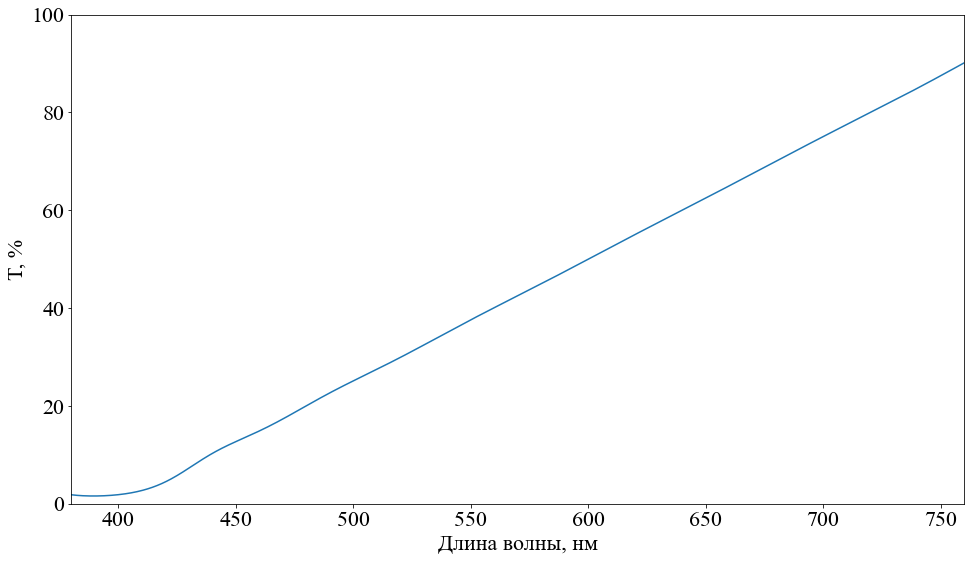

In [8]:
# Спектральная характеристика (Performance)
des.spectral_plot(q_TR='T', wv_bnd=[380, 760], q_subs=False, lang='ru')

## Кривая мониторинга

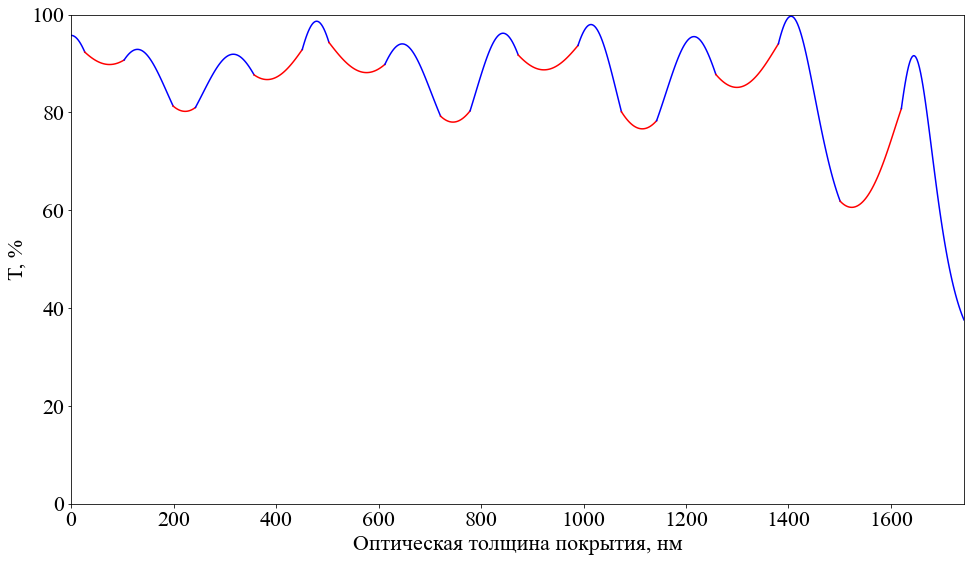

In [9]:
from opticalcoating.monitoring_curve_plot import monitoring_curve_plot

waves = [None] + des.N * [oc.Wave(550)]
monitoring_curve_plot(des=des, waves=waves, q_TR='T', control_wv=550, lang='ru', q_subs=False)

# Единичная симуляция

In [10]:
from time import perf_counter, time

In [11]:
# Алгоритмы прекращения напыления: 
# На выбор есть LM, QS, TM
term_algs = (des.N + 1) * ['QS']
# Длины волн, на которых ведется наблюдение
waves = [None] + des.N * [oc.Wave(550)]
# Скорости напыления
r_H, r_L = 0.4, 0.6
rates = [None] + [r_H if j % 2 else r_L for j in range(1, des.N + 1)]
# Ошибка в скорости напыления (стандартное отклонение)
rates_sigmas = [None] + [0.05 * r_H if j % 2 else 0.05 * r_L for j in range(1, des.N + 1)]

# Ошибка в измерении сигнала meas_sigmas=0.02 в абс. величинах (стандартное отклонение)
set_up_pars = oc.SetUpParameters(N=des.N, waves=waves, rates=rates, q_TR='T', meas_sigmas=0.005,
                                  rates_sigmas=rates_sigmas)

rnd_seed = int(1000000 * time())
task = {'des_th': des, 'term_algs': term_algs, 'set_up_pars': set_up_pars, 'rnd_seed': rnd_seed, 'save_M': True}

In [12]:
start = perf_counter()
sim = oc.simulation(**task)
stop = perf_counter()
print(f'Время одной симуляции: {stop - start:0.3f} c')

Время одной симуляции: 0.043 c


In [13]:
# Сохранение результата симуляции
sim.save()

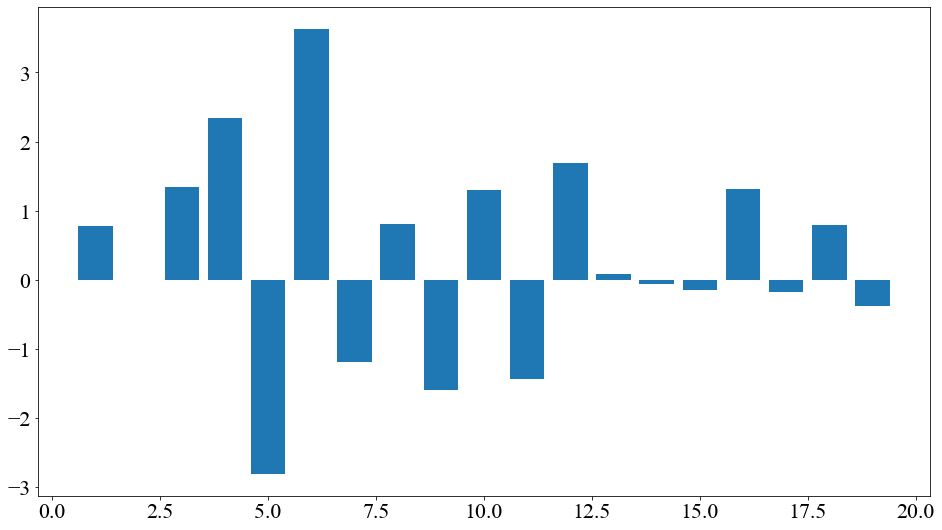

In [14]:
from matplotlib import rc
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

_ = plt.bar(range(1, des.N + 1), sim.errors_d[1:])

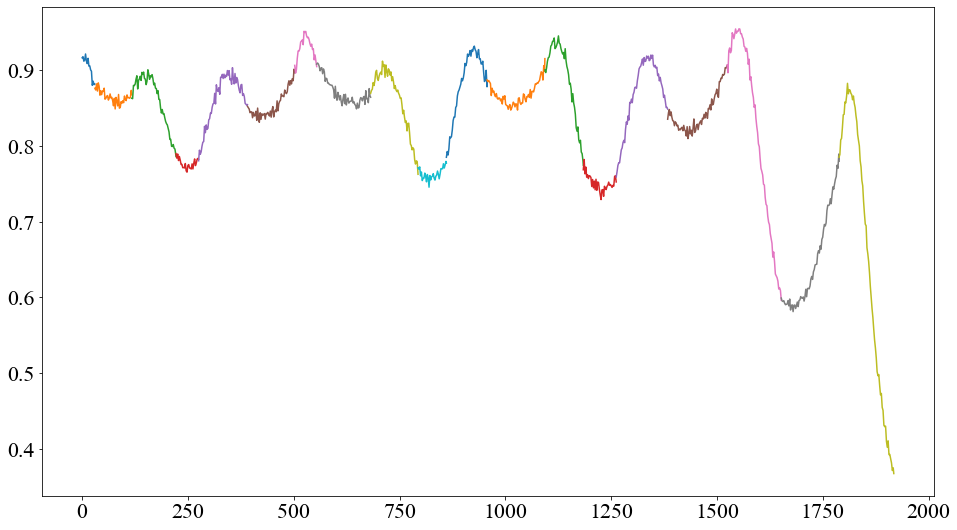

In [15]:
plt.figure(figsize=(16, 9))

for X, Y in zip(sim.time_list[1:], sim.flux_meas[1:]):
    plt.plot(X, Y)

# Сбор статистики

In [20]:
N_sim = 1000

# ----------- Статистика номер 4 ----------------
stat_num = 4

start_seed = int(1000000 * time())
tasks = [{'des_th': des, 'term_algs': term_algs, 'set_up_pars': set_up_pars, 'rnd_seed': rnd_seed, 'save_M': True}
         for rnd_seed in range(start_seed, start_seed + N_sim)]

start = perf_counter()
err_list = list(map(lambda kwarg: oc.simulation(**kwarg).errors_d[1:], tasks))
stop = perf_counter()
print(f'Statistics {stat_num}')
print(f'total time of calc = {(stop - start)} second')

res = oc.StatInfo.legacy(des, term_algs, set_up_pars, err_list, start_seed)
res.save()

Statistics 4
total time of calc = 41.9994949 second


## Визуализация ошибок

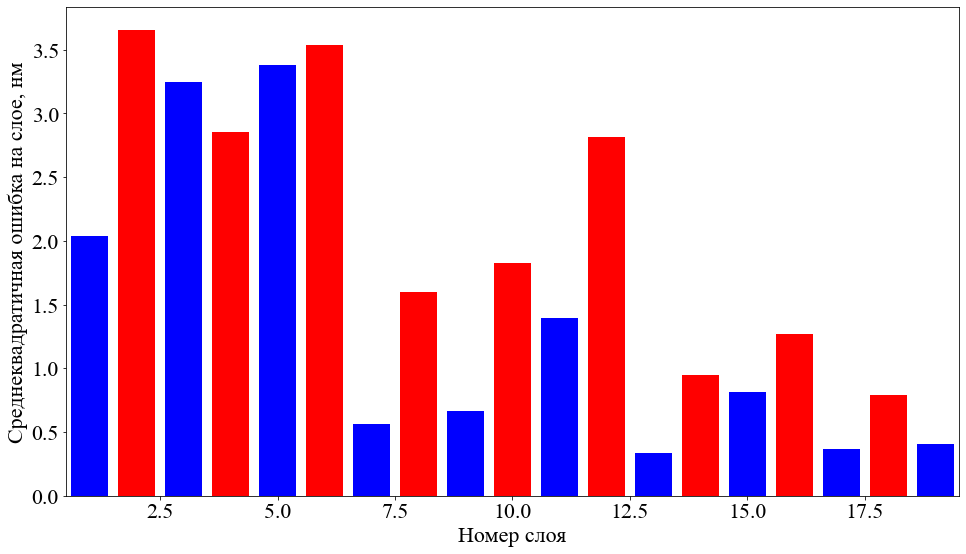

In [23]:
oc.StatInfo.load(stat_num).rms_bar(lang='ru')

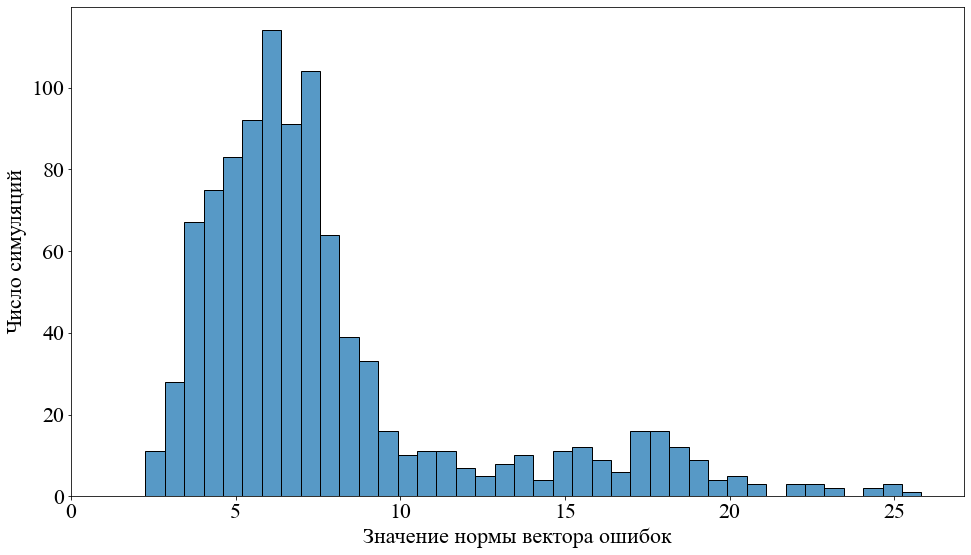

In [26]:
from opticalcoating.statistics_info import error_norm_hist

error_norm_hist(stat_num)

## Анализ ошибок

### Задание таргета

In [38]:
import json
from datetime import datetime

dct = {'name': 'RAMP19',
       'creation_time': datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
       'flux': 'T',
       'wv_list': [400, 450, 500, 550, 600, 650, 700, 750, 800],
       'flux_target': [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]}

with open(f"../../opticalcoating/resources/Targets/Target_{dct['name']}.json", 'w', encoding='utf-8') as file: json.dump(dct, file, indent=3)

In [43]:
start = perf_counter()
c_vals = oc.ProcessedStatistics.calc(des=des, target=oc.get_target('RAMP19'), statistic_num=stat_num)
stop = perf_counter()
print(f'time to calc c = {stop - start} second')
c_vals.save()

time to calc c = 1.4799882000002071 second
"c_value004.json" is successfully saved


In [54]:
print(f'Средняя норма ошибки {oc.mean_error_norm(stat_num):.2f} нм')
print(f'Коэф. самокомпенсации c = {oc.ProcessedStatistics.load(statistic_num=stat_num).c_value:.2f}')

Средняя норма ошибки 7.85 нм
Коэф. самокомпенсации 0.25


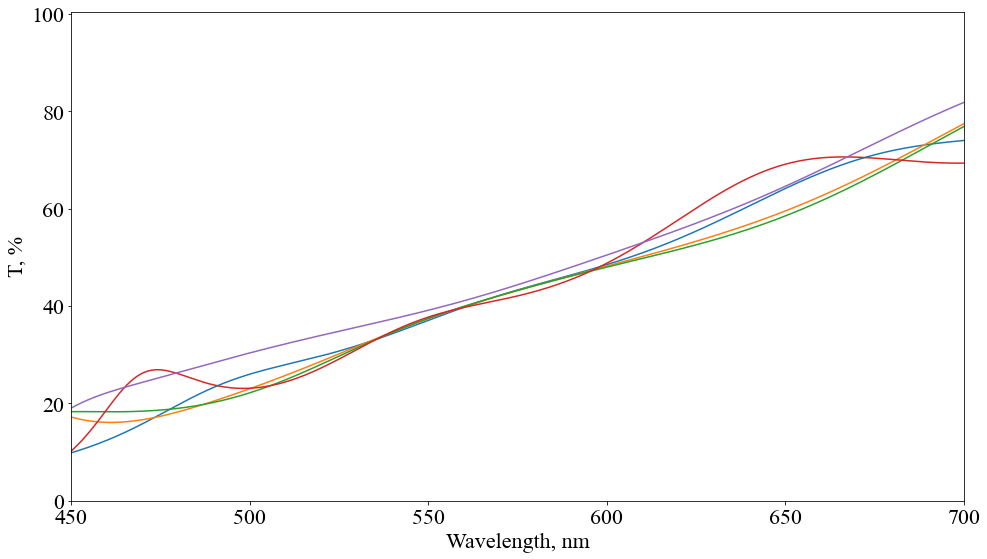

In [45]:
from opticalcoating.performance_plot import performance_plot

performance_plot(statistic_num=stat_num, amount=5, is_best=False, wv_bnd=[450, 700], q_subs=False, ylim=(0, 100.5))

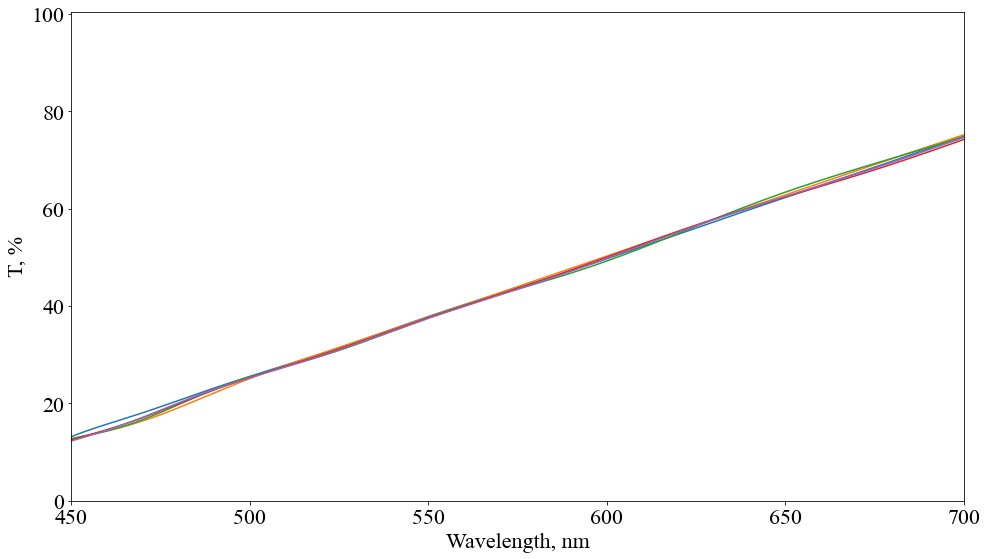

In [46]:
from opticalcoating.performance_plot import performance_plot

performance_plot(statistic_num=stat_num, amount=5, is_best=True, wv_bnd=[450, 700], q_subs=False, ylim=(0, 100.5))